# Baseline model (logistic regression)

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("df_to_train.csv")

#Now for my binary prediction I am going to exclude the first month of every customer, as they have a lot nan from the "trend"-features.
df.sort_values(["Customer_number", "FactDt"], inplace=True)
df_bi = df.loc[df.groupby('Customer_number').cumcount() > 0].copy()


#I am also going to exclude the last month for every customer that has BI-Label = 0, as these are the one I am the end want to calcualate an unbias probability to be first time investors.
df_bi = df_bi[~((df_bi['BI_Label'] == 0) & (df_bi.groupby('Customer_number')['FactDt'].transform('max') == df_bi['FactDt']))]

print('Rows before:', len(df))
print('Rows after :', len(df_bi))

Rows before: 70533
Rows after : 58184


In [2]:
#locate nan variables in the dataset
nan_cols = df_bi.columns[df_bi.isna().any()].tolist()
print("Columns with NaN values:", nan_cols)



Columns with NaN values: []


In [3]:
#Find columns that only has 0
zero_cols = df_bi.columns[(df_bi == 0).all()].tolist()
print("Columns with only 0 values:", zero_cols)

Columns with only 0 values: ['BOAT_LOANS', 'IsMarketingForLetterAllowed', 'AvgInvestmentsValueDKK']


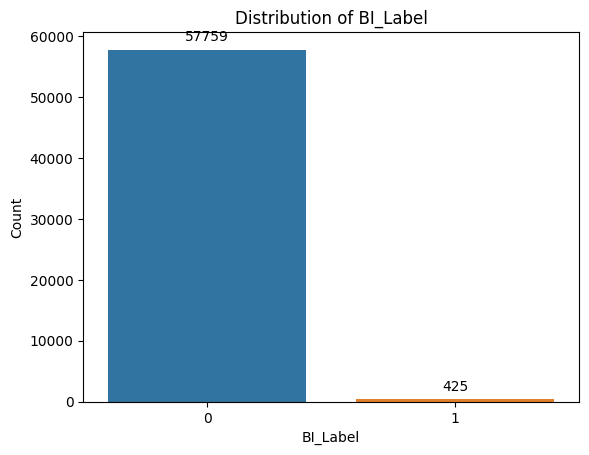

In [4]:
# plot the distribution of the target variable with actual counts on bars
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x='BI_Label', data=df_bi)
plt.title('Distribution of BI_Label')
plt.xlabel('BI_Label')
plt.ylabel('Count')

# add count labels
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(
        f'{height}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        xytext=(0, 4),
        textcoords='offset points'
    )

plt.show()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Column groups
# -----------------------------
binary_cols = [
    'CustGenderCd_M', 'CustGenderCd_N',
    'IsGeneralMarketingAllowed', 'IsMarketingForEmailAllowed',
    'IsMarketingForSmsAllowed', 'IsMarketingForLetterAllowed',
    'IsMarketingForPhoneAllowed', 'IsMarketingForEbankAllowed',
    'HomeLoan_taken_4m', 'CAR_LOANS_taken_4m'
]

minmax_cols = [
    'fam_members_diff_1m',
    'fam_members_change_dir',
    'fam_members_months_since_change',
    'fam_members_adult', 'fam_members',
    'HomeLoan_months_since_taken',
    'CAR_LOANS_months_since_taken'
]

financial_cols = [
    'Business_Volume', 'Gross_wealth', 'Net_Wealth', 'House_free_Equity',
    'Financial_Assets', 'RealEstateValue', 'HomeLoan', 'CAR_LOANS',
    'All_Loans', 'Other_loans',
    'AvgDepositsValueDKK', 'AvgPensionValueDKK', 'AvgHomeFinanceValueDKK',
    'AvgOtherLoansValueDKK',     'Deposits_Cards_lowest', 'Deposits_ordinary_lowest'
]

features = [
    'Business_Volume', 'Gross_wealth', 'Net_Wealth', 'House_free_Equity',
    'Financial_Assets', 'RealEstateValue', 'HomeLoan', 'CAR_LOANS',
    'All_Loans', 'Other_loans', 'CustAgeInYears',
    'CustGenderCd_M', 'CustGenderCd_N', 'fam_members_adult', 'fam_members',
    'CustMobileLogOnPerMth', 'CustNetBankLogOnPerMth',
    'IsGeneralMarketingAllowed', 'IsMarketingForEmailAllowed',
    'IsMarketingForSmsAllowed', 'IsMarketingForPhoneAllowed', 'IsMarketingForEbankAllowed',
    'AvgDepositsValueDKK', 'AvgPensionValueDKK', 'AvgHomeFinanceValueDKK',
    'AvgOtherLoansValueDKK',
    'Deposits_Cards_lowest', 'Deposits_ordinary_lowest',
    'Creditcard_overdraft_lowest', 'anc_y', 'Business_Volume_log_diff_1m_pct',
    'Business_Volume_trend_4m', 'Net_Wealth_log_diff_1m_pct',
    'Net_Wealth_trend_4m', 'Financial_Assets_log_diff_1m_pct',
    'Financial_Assets_trend_4m', 'CustMobileLogOnPerMth_diff_1m',
    'CustMobileLogOnPerMth_diff_4m_mean', 'CustNetBankLogOnPerMth_diff_1m',
    'CustNetBankLogOnPerMth_diff_4m_mean', 'fam_members_diff_1m',
    'fam_members_change_dir', 'fam_members_months_since_change',
    'HomeLoan_taken_4m', 'HomeLoan_months_since_taken',
    'CAR_LOANS_taken_4m', 'CAR_LOANS_months_since_taken'
]

def signed_log1p(s):
    s = pd.to_numeric(s, errors='coerce')
    return np.sign(s) * np.log1p(np.abs(s))

print('Setup ready. Financial vars:', len(financial_cols), '| Total candidate features:', len(features))

Setup ready. Financial vars: 16 | Total candidate features: 47


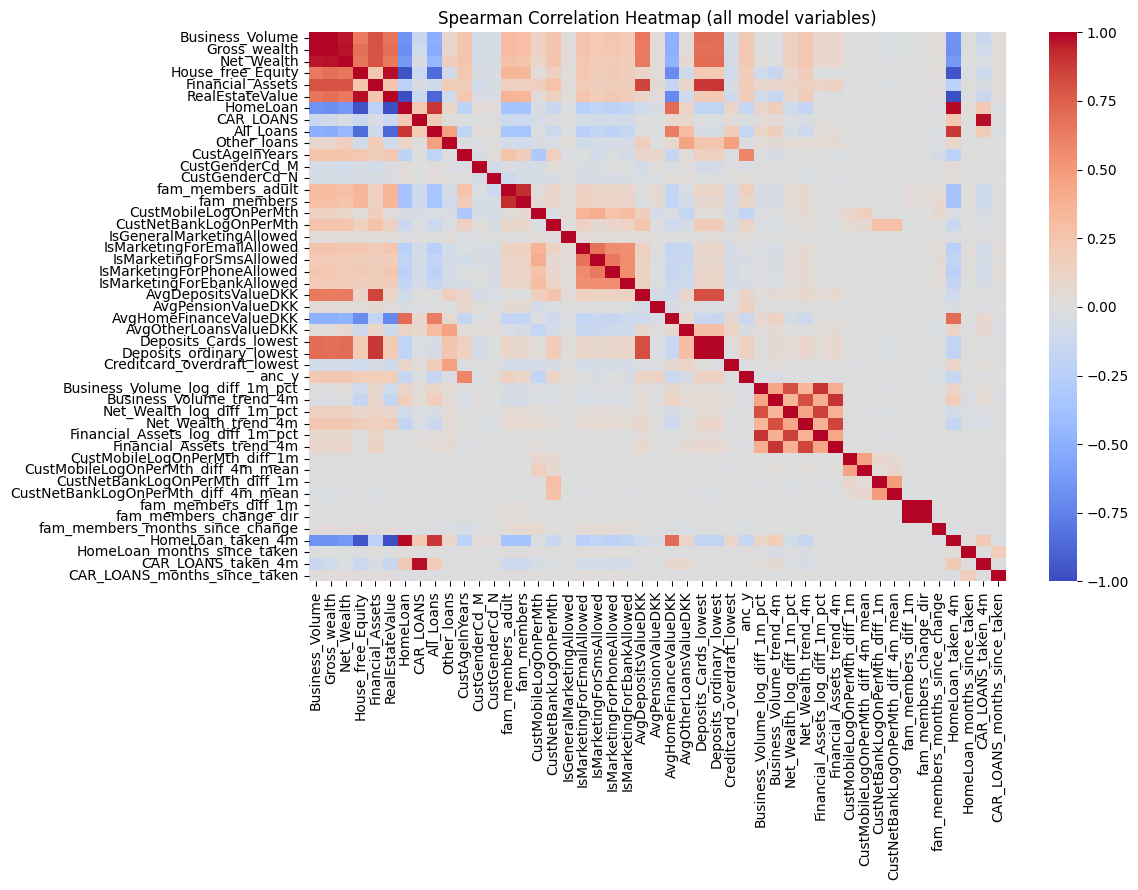

In [6]:
# 1) Heatmap of all model variables (before feature reduction)
all_model_cols = [c for c in features if c in df_bi.columns]
tmp_all = df_bi[all_model_cols].copy()

# numeric + safe values
for c in all_model_cols:
    tmp_all[c] = pd.to_numeric(tmp_all[c], errors='coerce')
tmp_all = tmp_all.replace([np.inf, -np.inf], np.nan)

corr_all = tmp_all.corr(method='spearman')

plt.figure(figsize=(12, 9))
sns.heatmap(corr_all, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Spearman Correlation Heatmap (all model variables)')
plt.tight_layout()
plt.show()

Feature importance from full feature set:


,feature,coef,odds_ratio,abs_coef,effect_on_label_1
34,fam_members_adult,1.756951,5.794742,1.756951,increases
35,fam_members,-1.669503,0.188341,1.669503,decreases
40,IsGeneralMarketingAllowed,-1.658284,0.190466,1.658284,decreases
16,CustAgeInYears,-1.129714,0.323126,1.129714,decreases
41,IsMarketingForEmailAllowed,1.102587,3.011947,1.102587,increases
3,House_free_Equity,0.901312,2.462832,0.901312,increases
36,HomeLoan_months_since_taken,0.667860,1.950059,0.667860,increases
14,Deposits_Cards_lowest,0.635564,1.888086,0.635564,increases
15,Deposits_ordinary_lowest,-0.634707,0.530091,0.634707,decreases
1,Gross_wealth,0.517247,1.677404,0.517247,increases


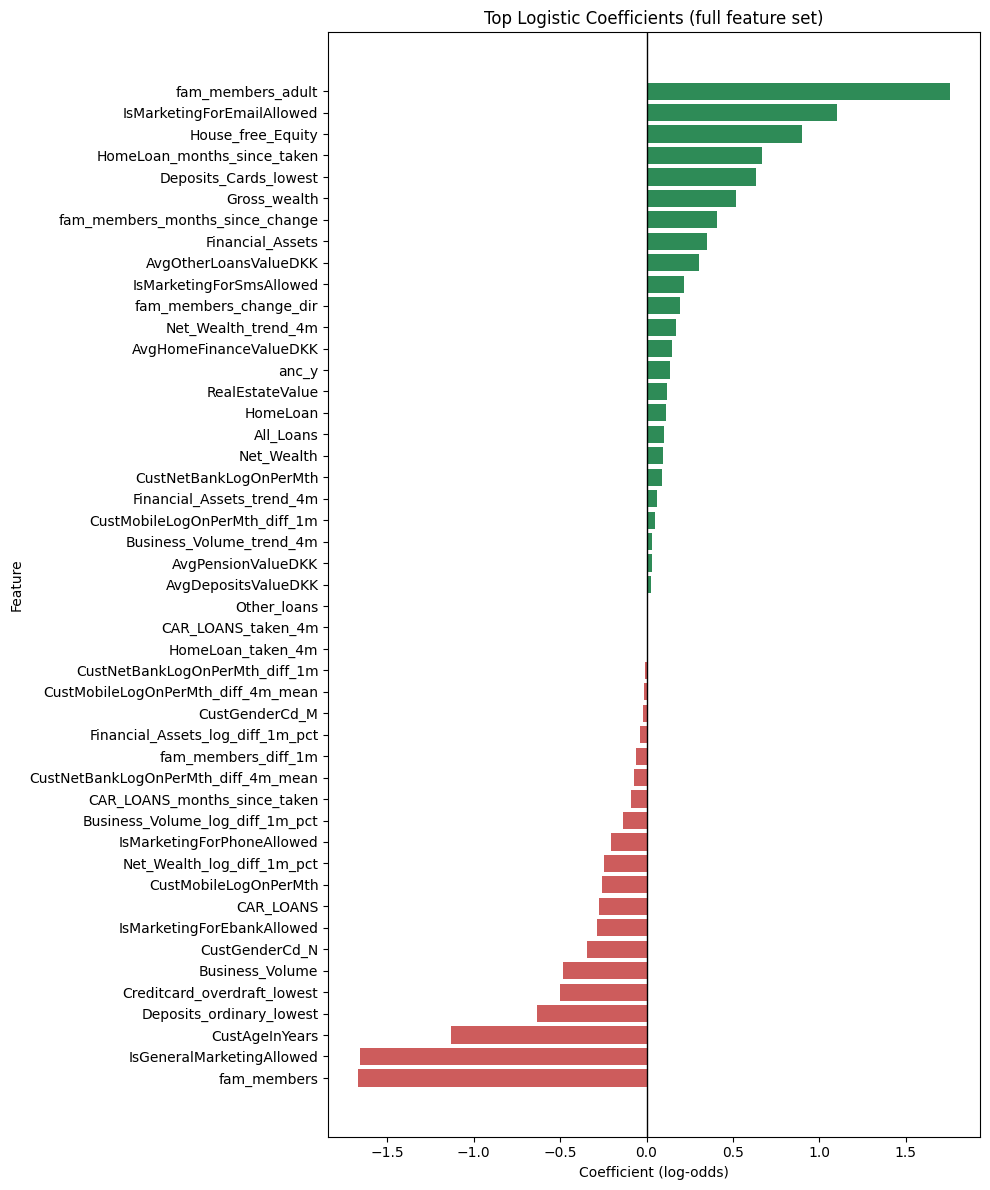

In [7]:
# 2) Fit on full feature set and extract feature importance
X_full = df_bi[[c for c in features if c in df_bi.columns]].copy()
X_full = X_full.replace([np.inf, -np.inf], np.nan)
y_full = df_bi['BI_Label'].astype(int).values

effective_binary_full = [c for c in binary_cols if c in X_full.columns]
effective_minmax_full = [c for c in minmax_cols if c in X_full.columns]
effective_financial_full = [c for c in financial_cols if c in X_full.columns]

all_specified_full = set(effective_binary_full) | set(effective_minmax_full) | set(effective_financial_full)
effective_standard_full = [c for c in X_full.columns if c not in all_specified_full]

def signed_log1p_np(arr):
    return np.sign(arr) * np.log1p(np.abs(arr))

signed_log_full = FunctionTransformer(signed_log1p_np, feature_names_out='one-to-one')

preprocess_full = ColumnTransformer(
    transformers=[
        ('fin', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('signed_log', signed_log_full),
            ('scaler', StandardScaler())
        ]), effective_financial_full),
        ('std', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), effective_standard_full),
        ('mm', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), effective_minmax_full),
        ('bin', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ]), effective_binary_full),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

model_full = LogisticRegression(max_iter=3000, class_weight='balanced', solver='liblinear')
pipe_full = Pipeline([('prep', preprocess_full), ('model', model_full)])
pipe_full.fit(X_full, y_full)

feature_names_full = pipe_full.named_steps['prep'].get_feature_names_out()
coefs_full = pipe_full.named_steps['model'].coef_[0]

importance_df = pd.DataFrame({
    'feature': feature_names_full,
    'coef': coefs_full,
    'odds_ratio': np.exp(coefs_full),
    'abs_coef': np.abs(coefs_full),
    'effect_on_label_1': np.where(coefs_full >= 0, 'increases', 'decreases')
}).sort_values('abs_coef', ascending=False)

print('Feature importance from full feature set:')
display(importance_df.head(40))

plot_df = importance_df.sort_values('coef', ascending=True)
colors = np.where(plot_df['coef'] >= 0, 'seagreen', 'indianred')

plt.figure(figsize=(10, 12))
plt.barh(plot_df['feature'], plot_df['coef'], color=colors)
plt.axvline(0, color='black', linewidth=1)
plt.title('Top Logistic Coefficients (full feature set)')
plt.xlabel('Coefficient (log-odds)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [8]:
# 3) Drop selected features after full-set importance review
drop_features = ['Other_loans', 'AvgDepositsValueDKK', 'Gross_wealth']

# Handle common spelling variant if present
if 'AvgDepositsValueDkk' in df_bi.columns and 'AvgDepositsValueDKK' not in df_bi.columns:
    drop_features = ['Other_loans', 'AvgDepositsValueDkk', 'Gross_wealth']

before_n = len(features)
features = [f for f in features if f not in drop_features and f in df_bi.columns]

# Keep grouping lists consistent with updated features
binary_cols = [c for c in binary_cols if c in features]
minmax_cols = [c for c in minmax_cols if c in features]
financial_cols = [c for c in financial_cols if c in features]

print('Dropped:', drop_features)
print('Features before:', before_n, '| after:', len(features))

Dropped: ['Other_loans', 'AvgDepositsValueDKK', 'Gross_wealth']
Features before: 47 | after: 44


In [9]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# X/y/groups from df_bi (based on current feature list)
X = df_bi[features].copy()
X = X.replace([np.inf, -np.inf], np.nan)
y = df_bi["BI_Label"].astype(int).values
groups = df_bi["Customer_number"].values

# Keep only columns that are present in current X and current features
effective_binary = [c for c in binary_cols if c in X.columns]
effective_minmax = [c for c in minmax_cols if c in X.columns]
effective_financial = [c for c in financial_cols if c in X.columns]

all_specified = set(effective_binary) | set(effective_minmax) | set(effective_financial)
effective_standard = [c for c in X.columns if c not in all_specified]

def signed_log1p_np(arr):
    return np.sign(arr) * np.log1p(np.abs(arr))

signed_log = FunctionTransformer(signed_log1p_np, feature_names_out="one-to-one")

preprocess = ColumnTransformer(
    transformers=[
        ("fin", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("signed_log", signed_log),
            ("scaler", StandardScaler())
        ]), effective_financial),
        ("std", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), effective_standard),
        ("mm", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler())
        ]), effective_minmax),
        ("bin", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent"))
        ]), effective_binary),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

log_reg = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    solver="liblinear"
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", log_reg)
])

# Customer-level stratification label (1 if customer ever has BI_Label=1)
cust_y = df_bi.groupby("Customer_number")["BI_Label"].max()
y_strat = df_bi["Customer_number"].map(cust_y).astype(int).values

cv = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

fold_pr, fold_roc = [], []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y_strat, groups=groups), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    pipe.fit(X_tr, y_tr)
    p_va = pipe.predict_proba(X_va)[:, 1]

    pr_auc = average_precision_score(y_va, p_va)
    roc_auc = roc_auc_score(y_va, p_va)

    fold_pr.append(pr_auc)
    fold_roc.append(roc_auc)

    print(f"Fold {fold}: PR-AUC={pr_auc:.4f} | ROC-AUC={roc_auc:.4f} | "
          f"Positives in val={y_va.sum()} / {len(y_va)}")

print("\nMean PR-AUC:", np.mean(fold_pr))
print("Std  PR-AUC:", np.std(fold_pr))
print("Mean ROC-AUC:", np.mean(fold_roc))
print("Std  ROC-AUC:", np.std(fold_roc))

Fold 1: PR-AUC=0.0208 | ROC-AUC=0.7011 | Positives in val=65 / 5792
Fold 2: PR-AUC=0.0202 | ROC-AUC=0.7245 | Positives in val=55 / 5728
Fold 3: PR-AUC=0.0576 | ROC-AUC=0.8093 | Positives in val=51 / 5833
Fold 4: PR-AUC=0.0181 | ROC-AUC=0.7086 | Positives in val=44 / 5804
Fold 5: PR-AUC=0.0042 | ROC-AUC=0.4688 | Positives in val=27 / 5847
Fold 6: PR-AUC=0.0078 | ROC-AUC=0.7004 | Positives in val=28 / 5904
Fold 7: PR-AUC=0.0328 | ROC-AUC=0.8136 | Positives in val=31 / 5856
Fold 8: PR-AUC=0.0168 | ROC-AUC=0.8443 | Positives in val=31 / 5805
Fold 9: PR-AUC=0.0169 | ROC-AUC=0.6809 | Positives in val=49 / 5784
Fold 10: PR-AUC=0.0197 | ROC-AUC=0.6786 | Positives in val=44 / 5831

Mean PR-AUC: 0.02148453113652523
Std  PR-AUC: 0.014059367404481021
Mean ROC-AUC: 0.7129934485272447
Std  ROC-AUC: 0.09946134119353985


In [96]:
#import joblib
# Save logistic regression pipeline + feature list for later scoring
logreg_artifact = {
    "model": pipe,
    "features": features
}

joblib.dump(logreg_artifact, "logreg_first_time_investor_model.joblib")
print("Saved: logreg_first_time_investor_model.joblib")

Saved: logreg_first_time_investor_model.joblib


# XGBoost classifier model

In [12]:
from xgboost import XGBClassifier
from sklearn.base import clone
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

# Reuse X, y, groups, y_strat, preprocess from your logistic setup
# X = df_bi[features]...
# y = ...
# groups = ...
# y_strat = ...
# preprocess = ...

cv = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

fold_pr, fold_roc = [], []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y_strat, groups=groups), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    # Compute imbalance weight on TRAIN fold only
    n_pos = y_tr.sum()
    n_neg = len(y_tr) - n_pos
    scale_pos_weight = (n_neg / n_pos) if n_pos > 0 else 1.0

    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0,
        objective="binary:logistic",
        eval_metric="aucpr",           # good for imbalance
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    )

    pipe_xgb = Pipeline([
        ("prep", clone(preprocess)),
        ("model", xgb)
    ])

    pipe_xgb.fit(X_tr, y_tr)

    p_va = pipe_xgb.predict_proba(X_va)[:, 1]

    pr_auc = average_precision_score(y_va, p_va)
    roc_auc = roc_auc_score(y_va, p_va)

    fold_pr.append(pr_auc)
    fold_roc.append(roc_auc)

    print(f"Fold {fold}: PR-AUC={pr_auc:.4f} | ROC-AUC={roc_auc:.4f} | "
          f"Positives in val={y_va.sum()} / {len(y_va)} | "
          f"scale_pos_weight={scale_pos_weight:.1f}")

print("\nMean PR-AUC:", np.mean(fold_pr))
print("Std  PR-AUC:", np.std(fold_pr))
print("Mean ROC-AUC:", np.mean(fold_roc))
print("Std  ROC-AUC:", np.std(fold_roc))


Fold 1: PR-AUC=0.0127 | ROC-AUC=0.5698 | Positives in val=65 / 5792 | scale_pos_weight=144.5
Fold 2: PR-AUC=0.0165 | ROC-AUC=0.5951 | Positives in val=55 / 5728 | scale_pos_weight=140.8
Fold 3: PR-AUC=0.0156 | ROC-AUC=0.7002 | Positives in val=51 / 5833 | scale_pos_weight=139.0
Fold 4: PR-AUC=0.0194 | ROC-AUC=0.6917 | Positives in val=44 / 5804 | scale_pos_weight=136.5
Fold 5: PR-AUC=0.0041 | ROC-AUC=0.4598 | Positives in val=27 / 5847 | scale_pos_weight=130.5
Fold 6: PR-AUC=0.0139 | ROC-AUC=0.8124 | Positives in val=28 / 5904 | scale_pos_weight=130.7
Fold 7: PR-AUC=0.0090 | ROC-AUC=0.6819 | Positives in val=31 / 5856 | scale_pos_weight=131.8
Fold 8: PR-AUC=0.0070 | ROC-AUC=0.5883 | Positives in val=31 / 5805 | scale_pos_weight=131.9
Fold 9: PR-AUC=0.0106 | ROC-AUC=0.5975 | Positives in val=49 / 5784 | scale_pos_weight=138.4
Fold 10: PR-AUC=0.0730 | ROC-AUC=0.6524 | Positives in val=44 / 5831 | scale_pos_weight=136.4

Mean PR-AUC: 0.018181677070355902
Std  PR-AUC: 0.01878864382442841
M

In [15]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold, ParameterGrid
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.base import clone
from xgboost import XGBClassifier

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# ~32 parameter sets
param_grid = {
    "max_depth": [3, 4],
    "min_child_weight": [10, 20],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "learning_rate": [0.03, 0.07],
}

base_params = dict(
    n_estimators=5000,              # large; early stopping will cap it
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=200,      
)

grid_list = list(ParameterGrid(param_grid))
print("Total parameter sets:", len(grid_list))

results = []
best_params = None
best_score = -np.inf

for i, params in enumerate(grid_list, start=1):
    fold_pr, fold_roc = [], []

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y_strat, groups=groups), start=1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # preprocess fit on train only
        prep = clone(preprocess)
        X_tr_p = prep.fit_transform(X_tr, y_tr)
        X_va_p = prep.transform(X_va)

        # scale_pos_weight on TRAIN fold only
        n_pos = y_tr.sum()
        n_neg = len(y_tr) - n_pos
        spw = (n_neg / n_pos) if n_pos > 0 else 1.0

        model = XGBClassifier(
            **base_params,
            **params,
            scale_pos_weight=spw,
            reg_lambda=2.0,          
            reg_alpha=0.0
        )

        model.fit(
            X_tr_p, y_tr,
            eval_set=[(X_va_p, y_va)],
            verbose=False
        )

        p_va = model.predict_proba(X_va_p)[:, 1]
        fold_pr.append(average_precision_score(y_va, p_va))
        fold_roc.append(roc_auc_score(y_va, p_va))

    mean_pr = float(np.mean(fold_pr))
    std_pr  = float(np.std(fold_pr))
    mean_roc = float(np.mean(fold_roc))
    std_roc  = float(np.std(fold_roc))

    results.append((mean_pr, std_pr, mean_roc, std_roc, params))

    print(f"[{i:02d}/{len(grid_list)}] "
          f"PR-AUC mean={mean_pr:.4f} (std={std_pr:.4f}) | "
          f"ROC-AUC mean={mean_roc:.4f} (std={std_roc:.4f}) | "
          f"params={params}")

    if mean_pr > best_score:
        best_score = mean_pr
        best_params = params

# Sort and show top results
results_sorted = sorted(results, key=lambda x: x[0], reverse=True)

print("\nBEST PARAMS (by mean PR-AUC):", best_params)
print("Best mean PR-AUC:", round(best_score, 4))

print("\nTop 3 parameter sets:")
for rank, (m_pr, s_pr, m_roc, s_roc, p) in enumerate(results_sorted[:3], start=1):
    print(f"{rank:02d}. PR-AUC={m_pr:.4f} (std={s_pr:.4f}) | "
          f"ROC-AUC={m_roc:.4f} (std={s_roc:.4f}) | {p}")


Total parameter sets: 32
[01/32] PR-AUC mean=0.0242 (std=0.0073) | ROC-AUC mean=0.6654 (std=0.0518) | params={'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7}
[02/32] PR-AUC mean=0.0273 (std=0.0145) | ROC-AUC mean=0.6671 (std=0.0605) | params={'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9}
[03/32] PR-AUC mean=0.0237 (std=0.0076) | ROC-AUC mean=0.6613 (std=0.0521) | params={'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 20, 'subsample': 0.7}
[04/32] PR-AUC mean=0.0289 (std=0.0153) | ROC-AUC mean=0.6685 (std=0.0582) | params={'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 20, 'subsample': 0.9}
[05/32] PR-AUC mean=0.0305 (std=0.0128) | ROC-AUC mean=0.6629 (std=0.0527) | params={'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7}
[06/32] PR-AUC mean=

In [16]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.base import clone
from xgboost import XGBClassifier

best_params = {
    "colsample_bytree": 0.9,
    "learning_rate": 0.07,
    "max_depth": 4,
    "min_child_weight": 20,
    "subsample": 0.9
}

base_params = dict(
    n_estimators=5000,          # large; early stopping picks the best
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=200   # put here to avoid the deprecation warning
)

cv10 = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

fold_pr, fold_roc, best_iters = [], [], []

for fold, (tr_idx, va_idx) in enumerate(cv10.split(X, y_strat, groups=groups), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    # preprocess within fold (no leakage)
    prep = clone(preprocess)
    X_tr_p = prep.fit_transform(X_tr, y_tr)
    X_va_p = prep.transform(X_va)

    # imbalance handling on train fold
    n_pos = y_tr.sum()
    n_neg = len(y_tr) - n_pos
    spw = (n_neg / n_pos) if n_pos > 0 else 1.0

    model = XGBClassifier(
        **base_params,
        **best_params,
        scale_pos_weight=spw,
        reg_lambda=2.0,   # keep fixed if you used it in search
        reg_alpha=0.0
    )

    model.fit(
        X_tr_p, y_tr,
        eval_set=[(X_va_p, y_va)],
        verbose=False
    )

    p_va = model.predict_proba(X_va_p)[:, 1]
    pr = average_precision_score(y_va, p_va)
    roc = roc_auc_score(y_va, p_va)

    fold_pr.append(pr)
    fold_roc.append(roc)
    best_iters.append(model.best_iteration)

    print(f"Fold {fold:02d}: PR-AUC={pr:.4f} | ROC-AUC={roc:.4f} | "
          f"best_iter={model.best_iteration} | Pos val={y_va.sum()}")

print("\nMean PR-AUC:", np.mean(fold_pr), "Std:", np.std(fold_pr))
print("Mean ROC-AUC:", np.mean(fold_roc), "Std:", np.std(fold_roc))
print("Avg best_iter:", int(np.mean(best_iters)))


Fold 01: PR-AUC=0.1652 | ROC-AUC=0.7077 | best_iter=5 | Pos val=65
Fold 02: PR-AUC=0.0255 | ROC-AUC=0.6273 | best_iter=8 | Pos val=55
Fold 03: PR-AUC=0.0262 | ROC-AUC=0.6894 | best_iter=1 | Pos val=51
Fold 04: PR-AUC=0.0379 | ROC-AUC=0.7298 | best_iter=572 | Pos val=44
Fold 05: PR-AUC=0.0098 | ROC-AUC=0.4484 | best_iter=1 | Pos val=27
Fold 06: PR-AUC=0.0313 | ROC-AUC=0.7925 | best_iter=74 | Pos val=28
Fold 07: PR-AUC=0.0132 | ROC-AUC=0.7062 | best_iter=32 | Pos val=31
Fold 08: PR-AUC=0.0224 | ROC-AUC=0.7124 | best_iter=58 | Pos val=31
Fold 09: PR-AUC=0.0411 | ROC-AUC=0.7059 | best_iter=14 | Pos val=49
Fold 10: PR-AUC=0.0997 | ROC-AUC=0.6041 | best_iter=135 | Pos val=44

Mean PR-AUC: 0.04722466247919514 Std: 0.04598024330729046
Mean ROC-AUC: 0.6723759153677991 Std: 0.08943131444601642
Avg best_iter: 90


In [17]:
import joblib
from sklearn.base import clone
from xgboost import XGBClassifier

# choose n_estimators based on CV best iterations
final_n_estimators = int(np.mean(best_iters))
final_n_estimators = max(final_n_estimators, 50)  # safety floor

# fit preprocess on ALL data
prep_final = clone(preprocess)
X_all_p = prep_final.fit_transform(X, y)

# scale_pos_weight on ALL data
n_pos_all = y.sum()
n_neg_all = len(y) - n_pos_all
spw_all = (n_neg_all / n_pos_all) if n_pos_all > 0 else 1.0

final_model = XGBClassifier(
    n_estimators=final_n_estimators,
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **best_params,
    scale_pos_weight=spw_all,
    reg_lambda=2.0,
    reg_alpha=0.0
)

final_model.fit(X_all_p, y)

# Save everything needed for later scoring
artifact = {
    "preprocess": prep_final,
    "model": final_model,
    "features": features
}

joblib.dump(artifact, "xgb_first_time_investor_model.joblib")
print("Saved: xgb_first_time_investor_model.joblib")


Saved: xgb_first_time_investor_model.joblib


In [18]:
#Shapley values: 
import joblib
import numpy as np
import pandas as pd

artifact = joblib.load("xgb_first_time_investor_model.joblib")
prep_final = artifact["preprocess"]
final_model = artifact["model"]
features = artifact["features"]

# Recreate transformed matrix (or reuse X_all_p if still in memory)
X = df_bi[features].copy().replace([np.inf, -np.inf], np.nan)
y = df_bi["BI_Label"].astype(int).values

X_all_p = prep_final.transform(X)   # preprocess already fitted in your saved artifact
feature_names = prep_final.get_feature_names_out()
print("Transformed features:", len(feature_names))


Transformed features: 44


/Users/antonsort/Dropbox/CBS/Kandidat/Kandidatafhandling/Kode/Master-thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


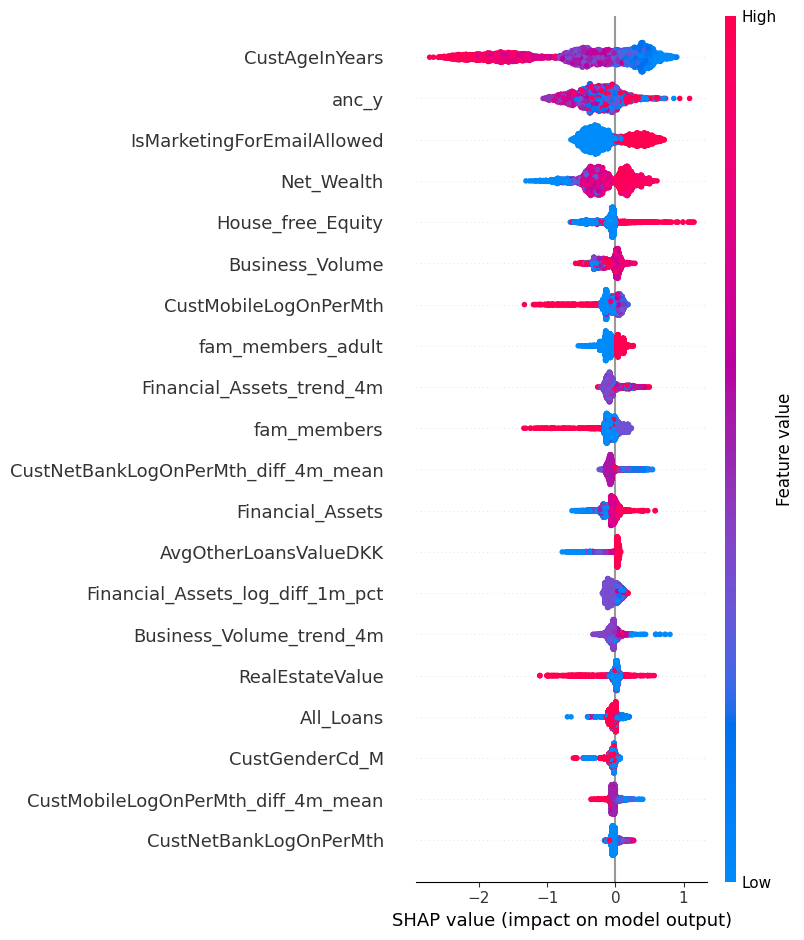

In [29]:
import shap
import numpy as np

# sample for speed (SHAP can be heavy)
rng = np.random.RandomState(42)
idx = rng.choice(X_all_p.shape[0], size=min(5000, X_all_p.shape[0]), replace=False)
X_shap = X_all_p[idx]

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, feature_names=feature_names)


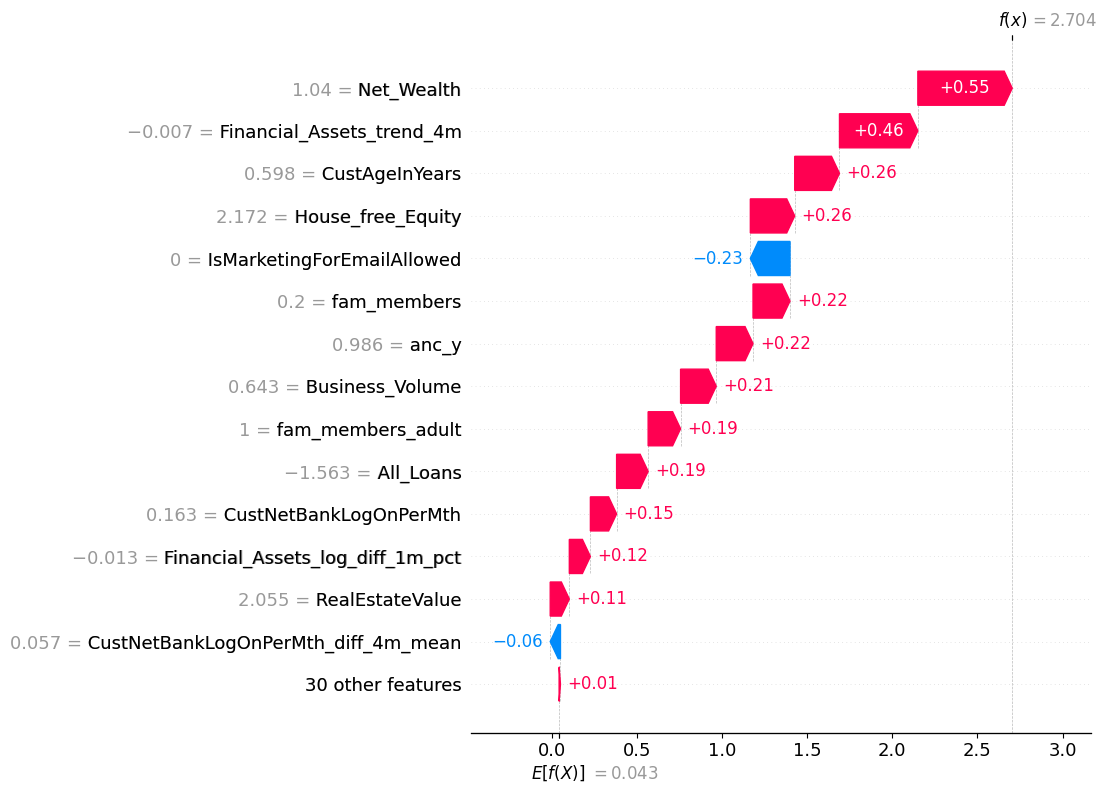

In [36]:
# predicted probs for the sample
pred = final_model.predict_proba(X_shap)[:, 1]
row = int(np.argmax(pred))  # most "likely" in sample

# New SHAP API (works in recent shap)
exp = shap.Explanation(
    values=shap_values[row],
    base_values=explainer.expected_value,
    data=X_shap[row],
    feature_names=feature_names
)

shap.plots.waterfall(exp, max_display=15)


In [37]:
import numpy as np
import pandas as pd

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_imp = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

shap_imp.tail(20)   # lowest-importance features


,feature,mean_abs_shap
11,Deposits_Cards_lowest,0.022006
12,Deposits_ordinary_lowest,0.021055
41,IsMarketingForEbankAllowed,0.018872
5,HomeLoan,0.017160
16,Creditcard_overdraft_lowest,0.016596
40,IsMarketingForPhoneAllowed,0.015615
9,AvgHomeFinanceValueDKK,0.015388
42,HomeLoan_taken_4m,0.013359
24,CustMobileLogOnPerMth_diff_1m,0.013231
6,CAR_LOANS,0.012369


In [ ]:
# correlation on transformed features
import numpy as np
import pandas as pd

X_shap_df = pd.DataFrame(X_shap, columns=feature_names)
corr = X_shap_df.corr(method="spearman").abs()

# list highly correlated pairs
pairs = []
threshold = 0.95
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        if corr.iat[i, j] > threshold:
            pairs.append((feature_names[i], feature_names[j], corr.iat[i, j]))

pairs = sorted(pairs, key=lambda x: x[2], reverse=True)
pairs[:10]


[('fam_members_diff_1m', 'fam_members_change_dir', 0.9999977910101902),
 ('HomeLoan', 'HomeLoan_taken_4m', 0.9954086750008962),
 ('Deposits_Cards_lowest', 'Deposits_ordinary_lowest', 0.995236123785123),
 ('RealEstateValue', 'HomeLoan', 0.9882927019287564),
 ('House_free_Equity', 'RealEstateValue', 0.987125556245663),
 ('RealEstateValue', 'HomeLoan_taken_4m', 0.984034414350901),
 ('CAR_LOANS', 'CAR_LOANS_taken_4m', 0.9823737538479019),
 ('House_free_Equity', 'HomeLoan', 0.9697057119073091),
 ('Business_Volume', 'Net_Wealth', 0.9693125039292835),
 ('House_free_Equity', 'HomeLoan_taken_4m', 0.9660140946835234)]

In [39]:
shap_rank = shap_imp.set_index("feature")["mean_abs_shap"]

to_drop = []
for a, b, c in pairs:
    drop = a if shap_rank[a] < shap_rank[b] else b
    to_drop.append(drop)

to_drop = sorted(set(to_drop))
to_drop[:20], len(to_drop)


(['Business_Volume',
  'CAR_LOANS_taken_4m',
  'Deposits_ordinary_lowest',
  'HomeLoan',
  'HomeLoan_taken_4m',
  'RealEstateValue',
  'fam_members_change_dir'],
 7)

In [ ]:
#Now i would try to drop some of these values and rerun and see if I got better performance and so on.

## TTE problem

In [ ]:
#Lets try to define the problem as a time to event using a Weibull TTE RRN - the data is not ideal, since we don't have much, but just to show how it theoretical could work. 
#The nice thing about this, when using a RRN, is that we dont have to worry about feature engineering time trends, as we just feed history (for example 4 months data history - if we have it) of the features we hypthesise have a time effect.
#to simplify a bit, we are gonna look at these time trends in variables: Net_Wealth, House_free_Equity, HomeLoan, and then the behavioural features: CustMobileLogOnPerMth, CustNetBankLogOnPerMth. 
# We are also gonna include some static features (that will not be input into the RNN) like: CustAgeInYears, CustGenderCd_M, CustGenderCd_N, fam_members_adult, fam_members, IsMarketingForEmailAllowed, anc_y

In [46]:
df_tte=df[['Customer_number', 'FactDt', 'Net_Wealth', 'House_free_Equity', 'HomeLoan', 'CustMobileLogOnPerMth',
'CustNetBankLogOnPerMth', 'CustAgeInYears', 'CustGenderCd_M', 'CustGenderCd_N', 'fam_members_adult', 'fam_members', 
'IsMarketingForEmailAllowed', 'anc_y', 'event_observed','TTE']]

In [47]:
df_tte

,Customer_number,FactDt,Net_Wealth,House_free_Equity,HomeLoan,CustMobileLogOnPerMth,CustNetBankLogOnPerMth,CustAgeInYears,CustGenderCd_M,CustGenderCd_N,fam_members_adult,fam_members,IsMarketingForEmailAllowed,anc_y,event_observed,TTE
0,000022D8D733FA51200BF5F45C37AED2,2022-01-31,13.45,0.00,0.00,0,0,28.0,0,0,2,2,0,1.264887,0,13.0
1,000022D8D733FA51200BF5F45C37AED2,2022-02-28,13.45,0.00,0.00,0,0,28.0,0,0,2,2,0,1.341547,0,12.0
2,000022D8D733FA51200BF5F45C37AED2,2022-03-31,13.45,0.00,0.00,0,0,28.0,0,0,2,2,0,1.426420,0,11.0
3,000022D8D733FA51200BF5F45C37AED2,2022-04-30,818.45,0.00,0.00,0,0,28.0,0,0,2,2,0,1.508556,0,10.0
4,000022D8D733FA51200BF5F45C37AED2,2022-05-31,818.45,0.00,0.00,0,0,28.0,0,0,2,2,0,1.593429,0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70528,0174CFCBED87171B4F6A651734F836E4,2022-07-31,2971980.95,2407313.61,-1392686.39,0,1,61.0,1,0,2,2,0,25.511294,0,7.0
70529,0174CFCBED87171B4F6A651734F836E4,2022-08-31,3050521.74,2489646.43,-1310353.57,0,1,61.0,1,0,2,2,0,25.596167,0,6.0
70530,0174CFCBED87171B4F6A651734F836E4,2022-09-30,3156168.71,2587028.87,-1212971.13,0,1,61.0,1,0,2,2,0,25.678303,0,5.0
70531,0174CFCBED87171B4F6A651734F836E4,2022-10-31,3102424.29,2523788.29,-1276211.71,0,2,61.0,1,0,2,2,0,25.763176,0,4.0


In [87]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

PAD_VALUE = -999.0
EPS = torch.finfo(torch.float32).eps
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [88]:
SEQ_COLS = ["Net_Wealth", "House_free_Equity", "HomeLoan",
            "CustMobileLogOnPerMth", "CustNetBankLogOnPerMth"]

STATIC_COLS = ["CustAgeInYears", "CustGenderCd_M", "CustGenderCd_N",
               "fam_members_adult", "fam_members",
               "IsMarketingForEmailAllowed", "anc_y"]

DATE_COL = "FactDt"
GROUP_COL = "Customer_number"

def make_windows(df, seq_cols, static_cols, seq_len=4):
    df = df.copy()
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df = df.sort_values([GROUP_COL, DATE_COL]).reset_index(drop=True)

    X_seq, X_static, tte, event, cust_ids = [], [], [], [], []

    for cust, g in df.groupby(GROUP_COL, sort=False):
        g = g.sort_values(DATE_COL).reset_index(drop=True)

        seq = g[seq_cols].to_numpy(dtype=float)        # (m, 5)
        stat = g[static_cols].to_numpy(dtype=float)    # (m, 7)
        t = g["TTE"].to_numpy(dtype=float)
        e = g["event_observed"].to_numpy(dtype=int)

        for i in range(len(g)):
            win = []
            for j in range(seq_len):
                idx = i - j
                if idx >= 0:
                    win.append(seq[idx])
                else:
                    win.append(np.full((len(seq_cols),), np.nan))
            X_seq.append(np.stack(win, axis=0))       # (4,5)
            X_static.append(stat[i])                  # (7,)
            tte.append(t[i])
            event.append(e[i])
            cust_ids.append(cust)

    return (np.stack(X_seq, axis=0),
            np.stack(X_static, axis=0),
            np.asarray(tte, dtype=float),
            np.asarray(event, dtype=int),
            np.asarray(cust_ids))

X_seq_raw, X_stat_raw, tte_all, ev_all, cust_ids = make_windows(df_tte, SEQ_COLS, STATIC_COLS, seq_len=4)
print("X_seq_raw:", X_seq_raw.shape, "X_stat_raw:", X_stat_raw.shape, "event_rate:", ev_all.mean())


X_seq_raw: (70533, 4, 5) X_stat_raw: (70533, 7) event_rate: 0.007344080075992797


In [89]:
cust_level = df_tte.groupby(GROUP_COL)["event_observed"].max().reset_index(name="cust_event")

train_cust, test_cust = train_test_split(
    cust_level[GROUP_COL],
    test_size=0.2,
    random_state=42,
    stratify=cust_level["cust_event"]
)

train_mask = np.isin(cust_ids, train_cust.values)
test_mask  = np.isin(cust_ids, test_cust.values)


X_seq_tr_raw, X_seq_te_raw = X_seq_raw[train_mask], X_seq_raw[test_mask]
X_stat_tr_raw, X_stat_te_raw = X_stat_raw[train_mask], X_stat_raw[test_mask]
tte_tr, tte_te = tte_all[train_mask], tte_all[test_mask]
ev_tr, ev_te   = ev_all[train_mask], ev_all[test_mask]

print("Train N:", len(tte_tr), "Test N:", len(tte_te))
print("Train events:", ev_tr.sum(), "Test events:", ev_te.sum())


Train N: 56406 Test N: 14127
Train events: 413 Test events: 105


In [90]:
def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Which indices in SEQ_COLS are which:
IDX_FIN = [0, 1, 2]  # wealth/equity/homeLoan
IDX_LOG = [3, 4]     # logins

def transform_seq(X):
    X = X.copy()
    X[..., IDX_FIN] = signed_log1p(X[..., IDX_FIN])
    X[..., IDX_LOG] = np.log1p(X[..., IDX_LOG])
    return X

X_seq_tr_t = transform_seq(X_seq_tr_raw)
X_seq_te_t = transform_seq(X_seq_te_raw)

# Fit StandardScaler on observed (non-NaN) sequence rows pooled over timesteps
scaler_seq = StandardScaler()
flat_tr = X_seq_tr_t.reshape(-1, X_seq_tr_t.shape[-1])  # (N*4, 5)
obs = ~np.isnan(flat_tr).any(axis=1)
scaler_seq.fit(flat_tr[obs])

def scale_seq(X_t, scaler):
    flat = X_t.reshape(-1, X_t.shape[-1])
    out = flat.copy()
    obs = ~np.isnan(out).any(axis=1)
    out[obs] = scaler.transform(out[obs])
    return out.reshape(X_t.shape)

X_seq_tr_s = scale_seq(X_seq_tr_t, scaler_seq)
X_seq_te_s = scale_seq(X_seq_te_t, scaler_seq)

# Replace NaNs with PAD_VALUE for packing
X_seq_tr = np.nan_to_num(X_seq_tr_s, nan=PAD_VALUE)
X_seq_te = np.nan_to_num(X_seq_te_s, nan=PAD_VALUE)

# Static scaling
# STATIC_COLS order:
# [Age, M, N, fam_adult, fam, EmailAllowed, anc_y]
STATIC_MINMAX_IDX = [0, 3, 4, 6]
scaler_static = MinMaxScaler()
scaler_static.fit(X_stat_tr_raw[:, STATIC_MINMAX_IDX])

def scale_static(Xs):
    Xo = Xs.copy()
    Xo[:, STATIC_MINMAX_IDX] = scaler_static.transform(Xo[:, STATIC_MINMAX_IDX])
    return Xo

X_stat_tr = scale_static(X_stat_tr_raw)
X_stat_te = scale_static(X_stat_te_raw)


In [92]:
def seq_lengths(X_seq):
    # X_seq: (N, 4, 5) padded with PAD_VALUE
    # timestep valid if any feature != PAD_VALUE
    valid = (X_seq != PAD_VALUE).any(axis=2)     # (N,4)
    L = valid.sum(axis=1)                        # (N,)
    return L.astype(np.int64)

L_tr = seq_lengths(X_seq_tr)
L_te = seq_lengths(X_seq_te)

class TTEDataset(Dataset):
    def __init__(self, X_seq, L, X_static, tte, event):
        self.X_seq = torch.tensor(X_seq, dtype=torch.float32)
        self.L = torch.tensor(L, dtype=torch.long)
        self.X_static = torch.tensor(X_static, dtype=torch.float32)
        self.tte = torch.tensor(tte, dtype=torch.float32)
        self.event = torch.tensor(event, dtype=torch.float32)

    def __len__(self):
        return len(self.tte)

    def __getitem__(self, idx):
        return self.X_seq[idx], self.L[idx], self.X_static[idx], self.tte[idx], self.event[idx]

train_ds = TTEDataset(X_seq_tr, L_tr, X_stat_tr, tte_tr, ev_tr)
test_ds  = TTEDataset(X_seq_te, L_te, X_stat_te, tte_te, ev_te)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=1024, shuffle=False, drop_last=False)


In [93]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, layers=1, dropout=0.0):
        super().__init__()
        rnn_dropout = 0.0 if layers < 2 else dropout
        self.rnn = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layers,
            batch_first=True,
            dropout=rnn_dropout
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, X, L):
        # X: (B, T, F), L: (B,) lengths
        # pack only sequences with L>0
        B, T, F = X.shape
        out = torch.full((B, self.rnn.hidden_size), PAD_VALUE, device=X.device)
        mask = L > 0
        if mask.any():
            packed = pack_padded_sequence(X[mask], L[mask].cpu(), batch_first=True, enforce_sorted=False)
            _, h = self.rnn(packed)       # h: (layers, Bmask, hidden)
            out[mask] = h[-1]
        return self.drop(out)

class FF(nn.Module):
    def __init__(self, dims, dropout=0.0, batchnorm=True, activation_out=True):
        super().__init__()
        layers = []
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2 or activation_out:
                if batchnorm:
                    layers.append(nn.BatchNorm1d(dims[i+1]))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class WeibullActivation(nn.Module):
    def __init__(self, init_alpha=1.0, max_beta=5.0, epsilon=EPS):
        super().__init__()
        self.init_alpha = init_alpha
        self.max_beta = max_beta
        self.eps = epsilon

    def forward(self, x):
        # x (...,2) -> alpha, beta
        alpha_raw = torch.clamp(x[..., 0], -10, 10)
        beta_raw  = torch.clamp(x[..., 1], -10, 10)

        alpha = self.init_alpha * torch.exp(alpha_raw)  # positive scale
        # bound beta in (0, max_beta)
        shift = torch.log(torch.tensor(self.max_beta - 1.0, device=x.device)) if self.max_beta > 1.05 else 0.0
        beta = self.max_beta * torch.clamp(torch.sigmoid(beta_raw - shift), min=self.eps, max=1.0 - self.eps)

        return alpha, beta

def weibull_nll(t, e, alpha, beta):
    # alpha=scale λ, beta=shape k
    t = torch.clamp(t, min=EPS)
    alpha = torch.clamp(alpha, min=EPS)
    beta = torch.clamp(beta, min=EPS)

    z = (t / alpha)
    pow_term = z ** beta

    # log f(t)
    log_f = torch.log(beta + EPS) - torch.log(alpha + EPS) + (beta - 1.0) * torch.log(z + EPS) - pow_term
    # log S(t)
    log_s = -pow_term

    nll = -(e * log_f + (1.0 - e) * log_s)
    return nll.mean()

class WeibullTTERNN(nn.Module):
    def __init__(
        self,
        seq_hidden=32,
        rnn_layers=1,                 
        static_hidden=[32, 16],
        out_hidden=[32, 16],
        dropout=0.1,
        init_alpha=1.0,
        max_beta=5.0
    ):
        super().__init__()

        self.seq_enc = RNNEncoder(
            input_dim=len(SEQ_COLS),
            hidden_dim=seq_hidden,
            layers=rnn_layers,         
            dropout=dropout
        )

        self.static_ff = FF(
            [len(STATIC_COLS)] + static_hidden,
            dropout=dropout,
            batchnorm=False,
            activation_out=True
        )

        self.out_ff = FF(
            [seq_hidden + static_hidden[-1]] + out_hidden + [2],
            dropout=dropout,
            batchnorm=True,
            activation_out=False
        )

        self.weib = WeibullActivation(init_alpha=init_alpha, max_beta=max_beta)

    def forward(self, x_seq, L, x_static):
        seq_emb = self.seq_enc(x_seq, L)
        stat_emb = self.static_ff(x_static)

        # handle PAD seq outputs (when L==0): replace with 0 vector
        mask = (L > 0).unsqueeze(1)
        seq_emb = torch.where(mask, seq_emb, torch.zeros_like(seq_emb))

        h = torch.cat([seq_emb, stat_emb], dim=1)
        out = self.out_ff(h)
        alpha, beta = self.weib(out)
        return alpha, beta

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import torch

@torch.no_grad()
def save_monitor_plot(
    model,
    test_loader,
    epoch,
    train_losses,
    test_losses,
    outpath,
    horizon=6,
    top_fracs=(0.01, 0.05, 0.10, 0.25),  # 1%, 5%, 10%, 25%
    min_n=50
):
 
    model.eval()

    # --- collect test predictions + outcomes ---
    all_t, all_e, all_alpha, all_beta = [], [], [], []
    for x_seq, L, x_stat, t, e in test_loader:
        x_seq = x_seq.to(DEVICE)
        L = L.to(DEVICE)
        x_stat = x_stat.to(DEVICE)

        alpha, beta = model(x_seq, L, x_stat)

        all_t.append(t.cpu().numpy())
        all_e.append(e.cpu().numpy())
        all_alpha.append(alpha.detach().cpu().numpy())
        all_beta.append(beta.detach().cpu().numpy())

    t = np.concatenate(all_t).astype(float)
    e = np.concatenate(all_e).astype(int)
    alpha = np.clip(np.concatenate(all_alpha).astype(float), 1e-8, None)
    beta  = np.clip(np.concatenate(all_beta).astype(float),  1e-8, None)

    # Predicted risk within horizon: 1 - S(h) where S(h)=exp(-(h/alpha)^beta)
    S_h = np.exp(- (horizon / alpha) ** beta)
    risk = 1.0 - S_h

    # Sort indices by risk descending (highest predicted risk first)
    order = np.argsort(-risk)
    N = len(risk)

    # --- figure with 2 panels ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # (A) KM lift plot: baseline + top fractions (manual plotting)
    ax = axes[0]
    kmf = KaplanMeierFitter()

    def km_step(ax, kmf_obj, label):
        sf = kmf_obj.survival_function_
        xs = sf.index.to_numpy()
        ys = sf.iloc[:, 0].to_numpy()
        ax.step(xs, ys, where="post", label=label)

    # Baseline (100%)
    kmf.fit(durations=t, event_observed=e)
    km_step(ax, kmf, f"Baseline (100%, n={N})")

    # Top slices
    for frac in top_fracs:
        k = int(np.ceil(frac * N))
        k = max(k, 1)
        idx = order[:k]

        label = f"Top {frac*100:.1f}% (n={len(idx)})"
        if len(idx) < min_n:
            label += " [small]"

        kmf.fit(durations=t[idx], event_observed=e[idx])
        km_step(ax, kmf, label)

    ax.set_title(f"Test Performance | Epoch {epoch}")
    ax.set_xlabel("Months")
    ax.set_ylabel("Survival P(no first-time invest yet)")
    ax.grid(alpha=0.2)
    ax.legend()

    # (B) Convergence plot
    ax2 = axes[1]
    x = np.arange(1, len(train_losses) + 1)
    ax2.plot(x, train_losses, marker="o", label="Train NLL")
    ax2.plot(x, test_losses, marker="o", label="Test NLL")
    ax2.set_title("Convergence (Weibull NLL)")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid(alpha=0.2)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close(fig)

    return outpath


In [ ]:
model = WeibullTTERNN(
    seq_hidden=32, static_hidden=[32,16], out_hidden=[32,16],
    dropout=0.1, init_alpha=1.0, max_beta=4.0
).to(DEVICE)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0
    n = 0
    for x_seq, L, x_stat, t, e in loader:
        x_seq = x_seq.to(DEVICE)
        L = L.to(DEVICE)
        x_stat = x_stat.to(DEVICE)
        t = t.to(DEVICE)
        e = e.to(DEVICE)

        alpha, beta = model(x_seq, L, x_stat)
        loss = weibull_nll(t, e, alpha, beta)

        if train:
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

        total += loss.item() * len(t)
        n += len(t)
    return total / n

best_val = float("inf")
patience = 5
pat = 0

train_losses, test_losses = [], []

for epoch in range(1, 51):
    tr_loss = run_epoch(train_loader, train=True)
    te_loss = run_epoch(test_loader, train=False)

    train_losses.append(tr_loss)
    test_losses.append(te_loss)

    print(f"Epoch {epoch:02d} | train NLL {tr_loss:.4f} | test NLL {te_loss:.4f}")

    if te_loss < best_val - 1e-4:
        best_val = te_loss
        pat = 0

        torch.save(model.state_dict(), "weibull_tte_rnn.pt")

        # Save KM (baseline + top 0.1/1/10%) + convergence plot side-by-side
        outpath = f"plots/monitor_epoch_{epoch:02d}.png"
        save_monitor_plot(
            model=model,
            test_loader=test_loader,
            epoch=epoch,
            train_losses=train_losses,
            test_losses=test_losses,
            outpath=outpath,
            horizon=6,
            min_n=50
        )
        print("Saved:", outpath)

    else:
        pat += 1
        if pat >= patience:
            print("Early stopping.")
            break

print("Best test NLL:", best_val)

Epoch 01 | train NLL 7.6481 | test NLL 1.6117
Saved: monitor_epoch_01.png
Epoch 02 | train NLL 1.1611 | test NLL 0.8472
Saved: monitor_epoch_02.png
Epoch 03 | train NLL 0.7400 | test NLL 0.6102
Saved: monitor_epoch_03.png
Epoch 04 | train NLL 0.5450 | test NLL 0.4158
Saved: monitor_epoch_04.png
Epoch 05 | train NLL 0.3700 | test NLL 0.2789
Saved: monitor_epoch_05.png
Epoch 06 | train NLL 0.2760 | test NLL 0.2379
Saved: monitor_epoch_06.png
Epoch 07 | train NLL 0.2403 | test NLL 0.1951
Saved: monitor_epoch_07.png
Epoch 08 | train NLL 0.1946 | test NLL 0.1513
Saved: monitor_epoch_08.png
Epoch 09 | train NLL 0.1209 | test NLL 0.0716
Saved: monitor_epoch_09.png
Epoch 10 | train NLL 0.0827 | test NLL 0.0623
Saved: monitor_epoch_10.png
Epoch 11 | train NLL 0.0750 | test NLL 0.0604
Saved: monitor_epoch_11.png
Epoch 12 | train NLL 0.0725 | test NLL 0.0603
Epoch 13 | train NLL 0.0707 | test NLL 0.0606
Epoch 14 | train NLL 0.0697 | test NLL 0.0608
Epoch 15 | train NLL 0.0664 | test NLL 0.0606
Ep

In [95]:
import os, json, csv
import numpy as np
import pandas as pd
import torch
import joblib

# -----------------------
# Folders
# -----------------------
ART_DIR = "final_tte_model"
PLOTS_DIR = os.path.join(ART_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# -----------------------
# Model
# -----------------------
model = WeibullTTERNN(
    seq_hidden=64,
    rnn_layers=2,
    static_hidden=[64, 32, 16],
    out_hidden=[64, 32, 16],
    dropout=0.2,
    init_alpha=1.0,
    max_beta=4.0
).to(DEVICE)

# -----------------------
# Optimizer + scheduler (remove deprecated verbose)
# -----------------------
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=2, min_lr=1e-5
)

def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0
    n = 0
    for x_seq, L, x_stat, t, e in loader:
        x_seq = x_seq.to(DEVICE)
        L = L.to(DEVICE)
        x_stat = x_stat.to(DEVICE)
        t = t.to(DEVICE)
        e = e.to(DEVICE)

        alpha, beta = model(x_seq, L, x_stat)
        loss = weibull_nll(t, e, alpha, beta)

        if train:
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

        total += loss.item() * len(t)
        n += len(t)
    return total / n

# -----------------------
# Helper: run model on test set and return arrays (no pandas needed for saving)
# -----------------------
@torch.no_grad()
def get_test_outputs_arrays(model, test_loader, horizon=6):
    model.eval()

    TTE_list, E_list, A_list, B_list, R_list = [], [], [], [], []

    for x_seq, L, x_stat, t, e in test_loader:
        x_seq = x_seq.to(DEVICE)
        L = L.to(DEVICE)
        x_stat = x_stat.to(DEVICE)

        alpha, beta = model(x_seq, L, x_stat)

        alpha = alpha.detach().cpu().numpy().astype(float)
        beta  = beta.detach().cpu().numpy().astype(float)
        t_np  = t.cpu().numpy().astype(float)
        e_np  = e.cpu().numpy().astype(int)

        alpha_c = np.clip(alpha, 1e-8, None)
        beta_c  = np.clip(beta,  1e-8, None)
        S_h = np.exp(- (horizon / alpha_c) ** beta_c)
        risk_h = 1.0 - S_h

        TTE_list.append(t_np)
        E_list.append(e_np)
        A_list.append(alpha)
        B_list.append(beta)
        R_list.append(risk_h)

    TTE = np.concatenate(TTE_list)
    E   = np.concatenate(E_list)
    A   = np.concatenate(A_list)
    B   = np.concatenate(B_list)
    R   = np.concatenate(R_list)

    return TTE, E, A, B, R

# -----------------------
# Train with "best model" saving + plot saving
# -----------------------
best_val = float("inf")
best_epoch = None
patience = 5
pat = 0

train_losses, test_losses = [], []

BEST_WEIGHTS_PATH = os.path.join(ART_DIR, "weibull_tte_rnn_best.pt")
BEST_OUTPUTS_NPZ  = os.path.join(ART_DIR, "test_outputs.npz")  # workaround file
BEST_OUTPUTS_CSV  = os.path.join(ART_DIR, "test_outputs.csv")  # optional manual csv
META_PATH = os.path.join(ART_DIR, "meta.json")
PREP_PATH = os.path.join(ART_DIR, "preprocess.joblib")

HORIZON = 6

for epoch in range(1, 51):
    tr_loss = run_epoch(train_loader, train=True)
    te_loss = run_epoch(test_loader, train=False)

    train_losses.append(tr_loss)
    test_losses.append(te_loss)

    scheduler.step(te_loss)
    current_lr = opt.param_groups[0]["lr"]

    print(f"Epoch {epoch:02d} | train NLL {tr_loss:.4f} | test NLL {te_loss:.4f} | lr={current_lr:.2e}")

    if te_loss < best_val - 1e-4:
        best_val = te_loss
        best_epoch = epoch
        pat = 0

        # 1) Save best weights
        torch.save(model.state_dict(), BEST_WEIGHTS_PATH)

        # 2) Save monitor plot into final_tte_model/plots
        outpath = os.path.join(PLOTS_DIR, f"monitor_best_epoch_{epoch:02d}.png")
        save_monitor_plot(
            model=model,
            test_loader=test_loader,
            epoch=epoch,
            train_losses=train_losses,
            test_losses=test_losses,
            outpath=outpath,
            top_fracs=(0.05, 0.10, 0.25),
            horizon=HORIZON,
            min_n=50
        )
        print("Saved BEST plot:", outpath)

        # 3) Save test outputs for later percentile/ranking comparisons (NO pandas.to_csv)
        TTE, E, A, B, R = get_test_outputs_arrays(model, test_loader, horizon=HORIZON)

        # Save as .npz (robust)
        np.savez(
            BEST_OUTPUTS_NPZ,
            TTE=TTE,
            event_observed=E,
            alpha=A,
            beta=B,
            **{f"risk_{HORIZON}m": R}
        )
        print("Saved test outputs:", BEST_OUTPUTS_NPZ)

        # Optional: also save a CSV using Python's csv module (bypasses pandas internals)
        with open(BEST_OUTPUTS_CSV, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["TTE", "event_observed", "alpha", "beta", f"risk_{HORIZON}m"])
            for row in zip(TTE, E, A, B, R):
                w.writerow(row)
        print("Saved test outputs (csv):", BEST_OUTPUTS_CSV)

        # 4) Save metadata
        meta = {
            "best_epoch": int(best_epoch),
            "best_test_nll": float(best_val),
            "horizon_months_for_risk": int(HORIZON),
            "model_params": {
                "seq_hidden": 64,
                "rnn_layers": 2,
                "static_hidden": [64, 32, 16],
                "out_hidden": [64, 32, 16],
                "dropout": 0.2,
                "init_alpha": 1.0,
                "max_beta": 4.0
            },
            "optimizer": {"lr": 1e-3, "weight_decay": 1e-4},
            "scheduler": {"type": "ReduceLROnPlateau", "factor": 0.5, "patience": 2, "min_lr": 1e-5},
        }
        with open(META_PATH, "w") as f:
            json.dump(meta, f, indent=2)
        print("Saved meta:", META_PATH)

        # 5) Save preprocess objects
        prep_bundle = {
            "SEQ_COLS": SEQ_COLS,
            "STATIC_COLS": STATIC_COLS,
            "PAD_VALUE": PAD_VALUE,
            "scaler_seq": scaler_seq,
            "scaler_static": scaler_static,
        }
        joblib.dump(prep_bundle, PREP_PATH)
        print("Saved preprocess:", PREP_PATH)

    else:
        pat += 1
        if pat >= patience:
            print("Early stopping.")
            break

print("Best test NLL:", best_val, "at epoch", best_epoch)
print("Artifacts saved in:", ART_DIR)


Epoch 01 | train NLL 4.9864 | test NLL 1.5855 | lr=1.00e-03
Saved BEST plot: final_tte_model/plots/monitor_best_epoch_01.png
Saved test outputs: final_tte_model/test_outputs.npz
Saved test outputs (csv): final_tte_model/test_outputs.csv
Saved meta: final_tte_model/meta.json
Saved preprocess: final_tte_model/preprocess.joblib
Epoch 02 | train NLL 1.2677 | test NLL 0.8921 | lr=1.00e-03
Saved BEST plot: final_tte_model/plots/monitor_best_epoch_02.png
Saved test outputs: final_tte_model/test_outputs.npz
Saved test outputs (csv): final_tte_model/test_outputs.csv
Saved meta: final_tte_model/meta.json
Saved preprocess: final_tte_model/preprocess.joblib
Epoch 03 | train NLL 0.8588 | test NLL 0.6519 | lr=1.00e-03
Saved BEST plot: final_tte_model/plots/monitor_best_epoch_03.png
Saved test outputs: final_tte_model/test_outputs.npz
Saved test outputs (csv): final_tte_model/test_outputs.csv
Saved meta: final_tte_model/meta.json
Saved preprocess: final_tte_model/preprocess.joblib
Epoch 04 | train NL

# Top 1000 new customers first time investors

In [117]:
df = pd.read_csv("df_to_train.csv")

#Now for my binary prediction I am going to exclude the first month of every customer, as they have a lot nan from the "trend"-features.
df.sort_values(["Customer_number", "FactDt"], inplace=True)

df_PI_new=df[(df['BI_Label'] == 0) & (df["FactDt"]=='2022-12-31')]

#save
print(len(df_PI_new), ' Potential new investors')
#save as df_pi_new.csv


5697  Potential new investors


In [118]:
import csv

out_path = "df_pi_new.csv"

with open(out_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(df_PI_new.columns)                 # header
    writer.writerows(df_PI_new.itertuples(index=False)) # rows

print("Saved:", out_path)


Saved: df_pi_new.csv


In [ ]:
# Load saved logistic regression artifact and score df_PI_new
artifact = joblib.load("logreg_first_time_investor_model.joblib")
pipe_lr = artifact["model"]
feat_lr = artifact["features"]

X_pi = df_PI_new[feat_lr].copy().replace([np.inf, -np.inf], np.nan)
proba = pipe_lr.predict_proba(X_pi)[:, 1]

df_top1000 = (
    df_PI_new.assign(prob_first_time_investor=proba)
    .sort_values("prob_first_time_investor", ascending=False)
    .head(1000)
    .reset_index(drop=True)
)
df_top1000.insert(0, "rank", np.arange(1, len(df_top1000) + 1))

df_top1000['model'] = "logreg_first_time_investor"



#save without pandas
import csv
out_path = "top1000_logreg_first_time_investor.csv"
with open(out_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Customer_number", "prob_first_time_investor", "rank", "model"])  # header
    writer.writerows(df_top1000[["Customer_number", "prob_first_time_investor", "rank", "model"]].itertuples(index=False))  # rows

In [124]:
df_top1000[["Customer_number", "prob_first_time_investor", "rank", "model"]].head(10)

,Customer_number,prob_first_time_investor,rank,model
0,00F9FDACA2282D4758F15AE3B88CBBFE,0.982131,1,logreg_first_time_investor
1,00B225D09B719A988008A8C3F96A340C,0.978218,2,logreg_first_time_investor
2,00A8B825A9E1895061C9D7EB024B4B65,0.974768,3,logreg_first_time_investor
3,016EC551ACA896A31030493E5493D2D1,0.972686,4,logreg_first_time_investor
4,0120B944A08FE599E10CFFCD6A273EE8,0.970975,5,logreg_first_time_investor
5,008E9599BFD0B1FA7845F3E1E4344E30,0.969552,6,logreg_first_time_investor
6,013D9FFBBCA7091055FB66D70A0141C1,0.964453,7,logreg_first_time_investor
7,0141813F181CAD4A42DE0DEC945A304D,0.960185,8,logreg_first_time_investor
8,00C78B28DBAAA0CB97854B1379D26494,0.958125,9,logreg_first_time_investor
9,007B1D8C425F5A519FDC6FA437571DFC,0.957959,10,logreg_first_time_investor


In [125]:
# Load saved XGBoost artifact and score df_PI_new
artifact_xgb = joblib.load("xgb_first_time_investor_model.joblib")
prep_xgb = artifact_xgb["preprocess"]
model_xgb = artifact_xgb["model"]
feat_xgb = artifact_xgb["features"]

X_pi_xgb = df_PI_new[feat_xgb].copy().replace([np.inf, -np.inf], np.nan)
X_pi_xgb_p = prep_xgb.transform(X_pi_xgb)
proba_xgb = model_xgb.predict_proba(X_pi_xgb_p)[:, 1]

df_top1000_xgb = (
    df_PI_new.assign(prob_first_time_investor=proba_xgb)
    .sort_values("prob_first_time_investor", ascending=False)
    .head(1000)
    .reset_index(drop=True)
)
df_top1000_xgb.insert(0, "rank", np.arange(1, len(df_top1000_xgb) + 1))
df_top1000_xgb["model"] = "xgb_first_time_investor"

df_top1000_xgb[["Customer_number", "prob_first_time_investor", "rank", "model"]].head(10)

# Save without pandas
out_path_xgb = "top1000_xgb_first_time_investor.csv"
with open(out_path_xgb, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Customer_number", "prob_first_time_investor", "rank", "model"])
    writer.writerows(
        df_top1000_xgb[["Customer_number", "prob_first_time_investor", "rank", "model"]]
        .itertuples(index=False)
    )

print("Saved:", out_path_xgb)

Saved: top1000_xgb_first_time_investor.csv


In [128]:
df_top1000_xgb[["Customer_number", "prob_first_time_investor", "rank", "model"]].head(10)

,Customer_number,prob_first_time_investor,rank,model
0,00D1D9984A36A99AB13B93B8FFE9F76E,0.888280,1,xgb_first_time_investor
1,00388B62A134D0E5A93A2732D89E08E1,0.870087,2,xgb_first_time_investor
2,00647CD67F831BBE16C59EB1D1792D75,0.868641,3,xgb_first_time_investor
3,0063F0D8E57743771E87AF1D2B592352,0.864077,4,xgb_first_time_investor
4,0043BA6DC1DFACE42DAB2E440E09AD87,0.859086,5,xgb_first_time_investor
5,010D5389B92047572BDA0B2E5BF85228,0.855520,6,xgb_first_time_investor
6,00E5414EA747DA1CD5AD0182136C7587,0.851972,7,xgb_first_time_investor
7,00523C6F211FC8DC5E7418020A9F8897,0.851385,8,xgb_first_time_investor
8,00F5E1599211966108D1446EEB616A65,0.850693,9,xgb_first_time_investor
9,00429809399624BAAFC81AA617447383,0.848829,10,xgb_first_time_investor


In [135]:
# Score df_PI_new with Weibull TTE model and rank vs test percentile
# Uses existing: WeibullTTERNN, SEQ_COLS, STATIC_COLS, PAD_VALUE, scaler_seq, scaler_static, DEVICE

# --- load test risk distribution ---
test_npz = np.load("final_tte_model/test_outputs.npz")
test_risk = test_npz["risk_6m"]
test_risk_sorted = np.sort(test_risk)
n_test = len(test_risk_sorted)

# --- build latest 4-month windows for df_PI_new customers ---
def build_latest_windows(df, customers, seq_cols, static_cols, seq_len=4):
    df = df[df[GROUP_COL].isin(customers)].copy()
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df = df.sort_values([GROUP_COL, DATE_COL])

    X_seq, X_stat, cust_ids = [], [], []
    for cust, g in df.groupby(GROUP_COL, sort=False):
        g = g.sort_values(DATE_COL)
        seq = g[seq_cols].to_numpy(dtype=float)
        stat = g[static_cols].to_numpy(dtype=float)

        i = len(g) - 1  # latest row
        win = []
        for j in range(seq_len):
            idx = i - j
            if idx >= 0:
                win.append(seq[idx])
            else:
                win.append(np.full((len(seq_cols),), np.nan))
        X_seq.append(np.stack(win, axis=0))
        X_stat.append(stat[i])
        cust_ids.append(cust)

    return np.stack(X_seq), np.stack(X_stat), np.asarray(cust_ids)

customers_pi = df_PI_new["Customer_number"].unique()
X_seq_pi_raw, X_stat_pi_raw, cust_ids_pi = build_latest_windows(
    df, customers_pi, SEQ_COLS, STATIC_COLS, seq_len=4
)

# --- apply same transforms/scaling as training ---
X_seq_pi_t = transform_seq(X_seq_pi_raw)
X_seq_pi_s = scale_seq(X_seq_pi_t, scaler_seq)
X_seq_pi = np.nan_to_num(X_seq_pi_s, nan=PAD_VALUE)

X_stat_pi = scale_static(X_stat_pi_raw)
L_pi = seq_lengths(X_seq_pi)

# --- load model and infer ---
model_tte = WeibullTTERNN(
    seq_hidden=64,
    rnn_layers=2,
    static_hidden=[64, 32, 16],
    out_hidden=[64, 32, 16],
    dropout=0.2,
    init_alpha=1.0,
    max_beta=4.0
).to(DEVICE)

model_tte.load_state_dict(torch.load("final_tte_model/weibull_tte_rnn_best.pt", map_location=DEVICE))
model_tte.eval()

with torch.no_grad():
    x_seq_t = torch.tensor(X_seq_pi, dtype=torch.float32, device=DEVICE)
    L_t = torch.tensor(L_pi, dtype=torch.long, device=DEVICE)
    x_stat_t = torch.tensor(X_stat_pi, dtype=torch.float32, device=DEVICE)

    alpha, beta = model_tte(x_seq_t, L_t, x_stat_t)

alpha_np = alpha.cpu().numpy().astype(float)
beta_np = beta.cpu().numpy().astype(float)

# Predicted risk within 6 months
HORIZON = 6
risk_6m = 1.0 - np.exp(- (HORIZON / np.clip(alpha_np, 1e-8, None)) ** np.clip(beta_np, 1e-8, None))

# Expected TTE (Weibull mean)
tte_pred = (alpha * torch.exp(torch.lgamma(1 + 1 / beta))).cpu().numpy().astype(float)

# Percentile rank vs test risk distribution
percentile = np.searchsorted(test_risk_sorted, risk_6m, side="right") / n_test

# Build output and rank
df_scores_tte = pd.DataFrame({
    "Customer_number": cust_ids_pi,
    "pred_tte": tte_pred,
    "risk_6m": risk_6m,
    "percentile_vs_test": percentile
}).sort_values("percentile_vs_test", ascending=False)

top_k = 1000
df_top1000_tte = df_scores_tte.head(top_k).reset_index(drop=True)
df_top1000_tte.insert(0, "rank", np.arange(1, len(df_top1000_tte) + 1))
df_top1000_tte["model"] = "weibull_tte_rnn_best"

df_top1000_tte.head(10)

,rank,Customer_number,pred_tte,risk_6m,percentile_vs_test,model
0,1,0115839F8707A3B4B05E95E633A38475,232.700211,0.015198,0.998797,weibull_tte_rnn_best
1,2,013C3B3794EE9AFFCCF95A670FFF4B7A,368.938599,0.012885,0.977915,weibull_tte_rnn_best
2,3,00D8EC2830EC1559B258EAA863DE8857,357.724213,0.012497,0.967014,weibull_tte_rnn_best
3,4,00213A221D160D58AD2B4D8B827A1E9B,342.574524,0.011984,0.961138,weibull_tte_rnn_best
4,5,00B8797D8ECBAA1DC488C5BB8AE812A0,376.569153,0.011376,0.954130,weibull_tte_rnn_best
5,6,00F779432C1D8521D1F0170487FCCB42,430.501343,0.011237,0.952290,weibull_tte_rnn_best
6,7,00DA8E1BD359828032078F0875DB5BC9,417.337311,0.010921,0.948114,weibull_tte_rnn_best
7,8,009ED89828878EBD1F1B086D34795DD3,425.620544,0.010027,0.933744,weibull_tte_rnn_best
8,9,00FE786C55D24BB229AA1148C6ABECC7,410.700897,0.009730,0.929851,weibull_tte_rnn_best
9,10,0020C54B9BB0D3752B15B7E4134EA4D1,429.790253,0.009466,0.926665,weibull_tte_rnn_best
